# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

In [57]:
!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-tools 1.66.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.5 which is incompatible.


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [58]:
!pip install -qU qdrant-client

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.232.1 requires protobuf<5.0,>=3.12, but you have protobuf 5.28.2 which is incompatible.
opentelemetry-proto 1.27.0 requires protobuf<5.0,>=3.19, but you have protobuf 5.28.2 which is incompatible.


We'll also provide our OpenAI key, as well as our Cohere API key.

In [59]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [60]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [61]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

/bin/bash: wget: command not found
/bin/bash: wget: command not found
/bin/bash: wget: command not found
/bin/bash: wget: command not found


### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [62]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [63]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2024, 9, 28, 13, 1, 30, 990860)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [64]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [65]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [66]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [67]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [68]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [69]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [70]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\nhttps://www.imdb.com/review/rw4854296/?ref_=tt_urv'

In [71]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the story revolves around an ex-hitman seeking revenge after gangsters kill his dog and take everything from him. This leads to a series of violent and action-packed events as he unleashes destruction on those who wronged him.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [72]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [73]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [74]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Opinions on John Wick seem to vary. Some people enjoyed the movie, praising its action sequences, style, and Keanu Reeves' performance, while others found it lacking in plot and substance. It ultimately depends on individual preferences."

In [75]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'No reviews have a rating of 10.'

In [76]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character, played by Keanu Reeves, is a retired hitman seeking vengeance for the killing of his dog, which was a gift from his recently deceased wife. The movie is praised for its beautifully choreographed action sequences and emotional setup.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [77]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [78]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [79]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [80]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [81]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick 2, after resolving his issues with the Russian mafia, John Wick returns home but is visited by mobster Santino D'Antonio who asks him to kill his sister in Rome. When John completes the task, Santino puts a contract on him, leading to a series of events where Wick promises to kill Santino."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [82]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [83]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [84]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [85]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'I am sorry, but there are no reviews with a rating of 10 in the provided context.'

In [86]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character, played by Keanu Reeves, is a retired assassin who comes out of retirement when someone kills his dog. He seeks revenge on those responsible by unleashing a maelstrom of destruction. In the sequel, John Wick 2, he is forced back into the world of assassins to honor a marker and faces challenges in Italy, Canada, and Manhattan while taking on numerous adversaries.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [87]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [88]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [89]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [90]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [91]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [92]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People's opinions on John Wick seem to vary. Some individuals like the series and find it consistent and well-received, while others have negative opinions about specific movies within the franchise. So, it really depends on the individual viewer's preferences."

In [93]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". The URL to that review is \'/review/rw4854296/?ref_=tt_urv\'.'

In [94]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the main character, played by Keanu Reeves, is a retired assassin who is forced back into action when someone kills his dog and steals his car. As a result, he goes on a rampage, killing many people in his quest for revenge. Additionally, in John Wick 2, he is called upon to pay off an old debt by helping take over the Assassin's Guild, leading to more violence and action in Italy, Canada, and Manhattan."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [95]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [96]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [97]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [98]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The review is for "John Wick 3" and the URL is \'/review/rw4854296/?ref_=tt_urv\'.'

In [99]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the story revolves around an ex-hitman seeking vengeance after gangsters kill his dog and steal his car. This sets off a series of events where John Wick faces off against mobsters, assassins, and a Russian mob prince. The movie is known for its intense action sequences, thrilling shootouts, and the unstoppable nature of John Wick as he seeks retribution for the wrongs done to him.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

In [100]:
!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [101]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [102]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [103]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [104]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [105]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [106]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that the majority of people enjoyed John Wick. Reviews consistently praise the action sequences, Keanu Reeves' performance, and the overall entertainment value of the movie. Therefore, it can be concluded that people generally liked John Wick."

In [107]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for "John Wick 3." Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\''

In [108]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hitman comes out of retirement to seek vengeance on the gangsters who killed his dog and took everything from him. The story is filled with violent action, shootouts, and breathtaking fights as John Wick unleashes a maelstrom of destruction against those who come after him. The movie is known for its fast-paced and intense action sequences, making it a thrilling and gripping watch.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

### YOUR CODE HERE

#### Set up Langsmith

In [109]:
import os
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"David - {unique_id}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")

#### Generate the synthetic dataset using the SDG.ipynb notebook in this repo

In [110]:
import pandas as pd 

synthetic_testset_df = pd.read_csv("synthetic_testset.csv")
synthetic_testset_df

,Unnamed: 0,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,0,What is the reputation of the John Wick action...,"["": 21\nReview: He fights and bites, he fights...",The John Wick action movie franchise is known ...,simple,"[{'source': 'john_wick_4.csv', 'row': 21, 'Rev...",True
1,1,What role does Iosef's uncle play in the plot ...,"["": 5\nReview: Iosef's uncle still has John Wi...",Iosef's uncle plays a role in the plot of John...,simple,"[{'source': 'john_wick_2.csv', 'row': 5, 'Revi...",True
2,2,How does John Wick: Chapter 3 - Parabellum exp...,"["": 24\nReview: John Wick: Chapter 3 - Parabel...",John Wick: Chapter 3 - Parabellum explores the...,simple,"[{'source': 'john_wick_3.csv', 'row': 24, 'Rev...",True
3,3,What role does the Continental hotel play in t...,"["": 20\nReview: After resolving his issues wit...","The Continental hotel in New York City, owned ...",simple,"[{'source': 'john_wick_2.csv', 'row': 20, 'Rev...",True
4,4,What is the premise of the John Wick movie ser...,"["": 19\nReview: If you've seen the first John ...",The premise of the John Wick movie series revo...,simple,"[{'source': 'john_wick_2.csv', 'row': 19, 'Rev...",True
5,5,Who is the mobster that visits John Wick and a...,"["": 20\nReview: After resolving his issues wit...",Santino D'Antonio is the mobster who visits Jo...,simple,"[{'source': 'john_wick_2.csv', 'row': 20, 'Rev...",True
6,6,What aspect of 'John Wick' received praise for...,[': 19\nReview: I really don\'t understand the...,The cinematography and fight choreography of '...,simple,"[{'source': 'john_wick_1.csv', 'row': 19, 'Rev...",True
7,7,What role does the marker play in the plot of ...,"["": 20\nReview: After resolving his issues wit...",The marker in the plot of John Wick: Chapter 2...,simple,"[{'source': 'john_wick_2.csv', 'row': 20, 'Rev...",True
8,8,What event in the movie John Wick Chapter 2 le...,"["": 10\nReview: Wow what a great surprise this...",The answer to given question is not present in...,simple,"[{'source': 'john_wick_1.csv', 'row': 10, 'Rev...",True
9,9,What role do assassins play in the artistic sp...,"["": 12\nReview: If there's an equivalent of cl...",Assassins play a significant role in the artis...,simple,"[{'source': 'john_wick_2.csv', 'row': 12, 'Rev...",True


# Create a function to test each chaing using the synthetic testset

In [111]:
from datasets import Dataset
import pandas as pd 

def test_chain(testset_path: str, chain) -> Dataset:
    
    testset_df = pd.read_csv(testset_path)

    answers = []
    contexts = []

    questions = testset_df["question"].values.tolist()
    groundtruths = testset_df["ground_truth"].values.tolist()

    # Loop over the list of synthetic questions and call the chain 
    for question in questions:
        print(question)

        # Call the chain
        response = chain.invoke({"question" : question})
        print(response)
        
        # Capture the answer and context 
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])

    data = {
        "question" : questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : groundtruths
        }

    response_ds = Dataset.from_dict(data)

    return response_ds

In [112]:
naive_chain_ds = test_chain("synthetic_testset.csv", naive_retrieval_chain)
naive_chain_ds.to_csv("datasets/naive_chain_ds.csv")
naive_chain_ds.info.description = "naive_chain_ds"

What is the reputation of the John Wick action movie franchise in terms of its overall tone and style?
{'response': AIMessage(content='The John Wick action movie franchise is known for its sleek, stylish, and kinetic action sequences that are well-choreographed and visually appealing. The overall tone of the franchise is fast-paced and intense, with a focus on revenge and brutal action. The franchise has been praised for its unique approach to the action genre and its ability to keep audiences entertained with its high-octane sequences.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 3558, 'total_tokens': 3635, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-600df662-593e-42bb-bf77-63e8ee130d48-0', usage_metadata={'input_tokens': 3558, 'output_tokens': 77, 'total_tokens': 3635}), 'context': [Docume

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 153.60ba/s]


In [113]:
bm25_chain_ds = test_chain("synthetic_testset.csv", bm25_retrieval_chain)
bm25_chain_ds.to_csv("datasets/bm25_chain_ds.csv")
bm25_chain_ds.info.description = "bm25_chain_ds"

What is the reputation of the John Wick action movie franchise in terms of its overall tone and style?
{'response': AIMessage(content='The John Wick action movie franchise is known for its stylish visuals, hardcore action, suspenseful sequences, and entertaining action scenes. The overall tone and style of the franchise are characterized by intense and well-choreographed action, with a focus on revenge themes and personal backstabbing. The movies are praised for their inventiveness in action sequences, hand-to-hand combat, and sheer enjoyment factor. Overall, the reputation of the John Wick franchise in terms of its tone and style is highly positive.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 1587, 'total_tokens': 1685, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-31fe5953-9272-44db-a679-07

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 444.26ba/s]


In [114]:
contextual_compression_chain_ds = test_chain("synthetic_testset.csv", contextual_compression_retrieval_chain)
contextual_compression_chain_ds.to_csv("datasets/contextual_compression_chain_ds.csv")
contextual_compression_chain_ds.info.description = "contextual_compression_chain_ds"

What is the reputation of the John Wick action movie franchise in terms of its overall tone and style?
{'response': AIMessage(content='The reputation of the John Wick action movie franchise is highly positive in terms of its overall tone and style. It is described as slick, violent fun with expertly choreographed action sequences, cool characters, and a unique underworld setting. Fans of action movies and those looking for something different from the usual fare highly recommend the franchise.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 1617, 'total_tokens': 1682, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-32331dd0-0f00-45b7-b790-4d5d5b35f753-0', usage_metadata={'input_tokens': 1617, 'output_tokens': 65, 'total_tokens': 1682}), 'context': [Document(metadata={'source': 'john_wick_1.csv', 'r

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 255.24ba/s]


In [115]:
multi_query_chain_ds = test_chain("synthetic_testset.csv", multi_query_retrieval_chain)
multi_query_chain_ds.to_csv("datasets/multi_query_chain_ds.csv")
multi_query_chain_ds.info.description = "multi_query_chain_ds"

What is the reputation of the John Wick action movie franchise in terms of its overall tone and style?
{'response': AIMessage(content='The John Wick action movie franchise is highly regarded for its overall tone and style. It is considered to be slick, cool, violent, and fun, with well-choreographed action sequences and a unique take on the revenge thriller genre. The first film in the franchise is particularly praised for its stylish stunts, kinetic chaos, and relatable hero. The franchise has set new standards for action filmmaking and has been consistently well-received by audiences.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 4819, 'total_tokens': 4909, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-f6dddac6-89a5-4bf3-a979-10da2b7a14b7-0', usage_metadata={'input_tokens': 4819, 'output_toke

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 108.68ba/s]


In [116]:
parent_document_chain_ds = test_chain("synthetic_testset.csv", parent_document_retrieval_chain)
parent_document_chain_ds.to_csv("datasets/parent_document_chain_ds.csv")
parent_document_chain_ds.info.description = "parent_document_chain_ds"

What is the reputation of the John Wick action movie franchise in terms of its overall tone and style?
{'response': AIMessage(content='The reputation of the John Wick action movie franchise is highly regarded for its exceptional action sequences, expert choreography, and creative filmmaking. It has set a standard for what action in Hollywood should be and is considered one of the best action movie franchises.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 356, 'total_tokens': 406, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-16ce26d7-05d9-4474-ad4a-bf41dc37064c-0', usage_metadata={'input_tokens': 356, 'output_tokens': 50, 'total_tokens': 406}), 'context': [Document(metadata={'source': 'john_wick_4.csv', 'row': 18, 'Review_Date': '17 March 2023', 'Review_Title': ' Not Just The Best John Wick, Bu

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 356.02ba/s]


In [117]:
ensemble_chain_ds = test_chain("synthetic_testset.csv", ensemble_retrieval_chain)
ensemble_chain_ds.to_csv("datasets/ensemble_chain_ds.csv")
ensemble_chain_ds.info.description = "ensemble_chain_ds"

What is the reputation of the John Wick action movie franchise in terms of its overall tone and style?
{'response': AIMessage(content='The reputation of the John Wick action movie franchise is highly regarded for its overall tone and style. It is described as slick, cool, violent, brutal, and fun by reviewers. The action sequences are highlighted for being expertly choreographed, shot, and edited, setting a standard for action in Hollywood. The films are known for their creativity, stylish stunts, kinetic chaos, and sheer intensity that keeps viewers entertained. The franchise is considered a remarkable, surprising, and enjoyable experience, with each installment maintaining the elements that made it successful while expanding the story.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 112, 'prompt_tokens': 5251, 'total_tokens': 5363, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerpr

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 131.44ba/s]


In [118]:
semantic_chain_ds = test_chain("synthetic_testset.csv", semantic_retrieval_chain)
semantic_chain_ds.to_csv("datasets/semantic_chain_ds.csv")
semantic_chain_ds.info.description = "semantic_chain_ds"

What is the reputation of the John Wick action movie franchise in terms of its overall tone and style?
{'response': AIMessage(content='The John Wick action movie franchise is highly praised for its overall tone and style, described as slick, cool, violent, and stylish. The action sequences are expertly choreographed and shot, with a focus on kinetic chaos and fluid movement. The franchise has set new standards in action filmmaking and is known for delivering intense and entertaining experiences.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 3138, 'total_tokens': 3206, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d4e7d0ac-31c7-4786-9c4f-a171c1325421-0', usage_metadata={'input_tokens': 3138, 'output_tokens': 68, 'total_tokens': 3206}), 'context': [Document(metadata={'source': 'john_wick_1.csv', 

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 159.89ba/s]


#### Run Ragas evaluations on the retrieval chain datasets using metrics focused on retrieval

In [119]:
from ragas import evaluate
from ragas.metrics import (
    context_recall,             # Context recall measures if all the relevant information required to answer the question was retrieved. This metric is computed based on the ground_truth 
    context_precision,          # Context precision measures the signal-to-noise ratio of the retrieved context. This metric is computed using the question and the contexts.
)

metrics = [
    context_recall,
    context_precision,
]

/opt/anaconda3/envs/aie4/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAIBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/anaconda3/envs/aie4/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAICommon has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/anaconda3/envs/aie4/lib/python3.11/site-packages/ragas/metrics/__init__.py:4: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_

In [120]:
datasets = [naive_chain_ds,
         bm25_chain_ds,
         contextual_compression_chain_ds,
         multi_query_chain_ds,
         parent_document_chain_ds,
         ensemble_chain_ds,
         semantic_chain_ds,
         ]

In [121]:
ragas_results = []

for dataset in datasets:
    dataset_name = dataset.info.description
    print(dataset_name)
    
    ragas_result = evaluate(dataset, metrics)

    ragas_results_df = ragas_result.to_pandas() 
    
    ragas_results_df.to_csv(f"ragas/{dataset_name}_ragas_results.csv")
    
    ragas_results.append(ragas_result)



naive_chain_ds


Evaluating: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


bm25_chain_ds


Evaluating: 100%|██████████| 38/38 [00:55<00:00,  1.47s/it]


contextual_compression_chain_ds


Evaluating: 100%|██████████| 38/38 [00:18<00:00,  2.04it/s]


multi_query_chain_ds


Evaluating: 100%|██████████| 38/38 [02:12<00:00,  3.48s/it]


parent_document_chain_ds


Evaluating: 100%|██████████| 38/38 [00:08<00:00,  4.54it/s]


ensemble_chain_ds


Evaluating: 100%|██████████| 38/38 [02:14<00:00,  3.54s/it]


semantic_chain_ds


Evaluating: 100%|██████████| 38/38 [01:04<00:00,  1.70s/it]


In [122]:
for ragas_result in ragas_results:
    print(ragas_result)

{'context_recall': 0.8202, 'context_precision': 0.8026}
{'context_recall': 0.6798, 'context_precision': 0.7032}
{'context_recall': 0.8026, 'context_precision': 0.8772}
{'context_recall': 0.8259, 'context_precision': 0.7120}
{'context_recall': 0.7149, 'context_precision': 0.8158}
{'context_recall': 0.7851, 'context_precision': 0.7436}
{'context_recall': 0.7579, 'context_precision': 0.7343}


#### Analysis

See "Tracing.ipynb" in this repo for the notebook that I used to generate the traces in LangSmith.

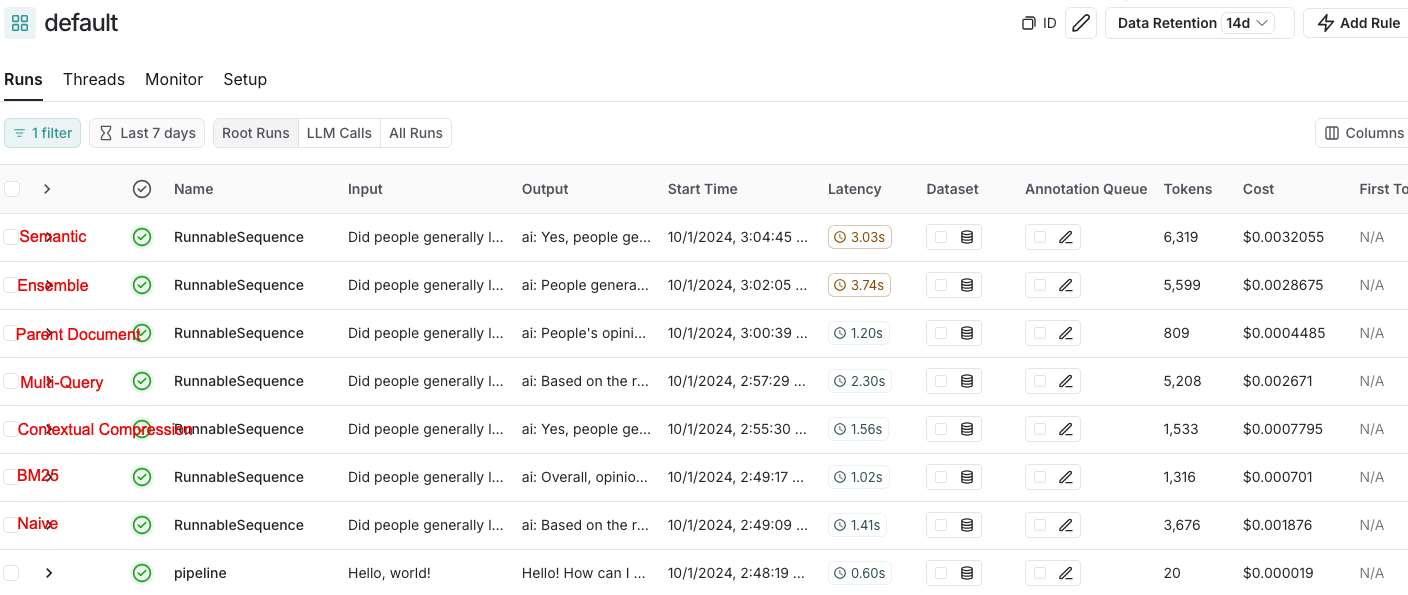